# Text Classification of Recipes
**A Comparison of TF-IDF and SBERT Embeddings for Supervised Learning**

Team Members:
* Faraiba Farnan Tabinda
* Maleha Afzal

## 1. Introduction and Goal
This project explores how different text representation methods influence recipe classification. The aim is to predict each recipe’s category based on its content.

We compare two approaches:
- TF-IDF, a simple keyword-based method
- SBERT, a modern semantic embedding model
Through classification, EDA, and visualization, we examine how these techniques help us understand patterns and topics in recipes.

## 2. Setup and Data Preparation

First, we install and import the necessary libraries. 

### 2.1. Installations

The following libraries are required.

In [39]:
import pandas as pd
import numpy as np
import re
import json
import os
import json
import argparse
import pandas as pd
import numpy as np
from scipy import sparse

# Sklearn for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer



c:\Users\GP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Loading the dataset
csv_path = r'c:\Users\GP\AAU_BDS\Semester 01\Course02_Natural Language Processing\mini assignment\1_Recipe.csv'
df = pd.read_csv(csv_path)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     2674 non-null   object
 1   category         2674 non-null   object
 2   subcategory      2674 non-null   object
 3   description      2674 non-null   object
 4   ingredients      2674 non-null   object
 5   directions       2674 non-null   object
 6   num_ingredients  2674 non-null   int64 
 7   num_steps        2674 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 167.3+ KB


In [43]:
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Carrot Apple Pancakes,Breakfast And Brunch,Breakfast And Brunch,"These carrot apple pancakes, inspired by a car...","[""1 cup grated carrot"", ""5 tablespoons unsalte...","[""Peel and grate enough carrot to fill a 1-cup...",11,5
1,Cottage Cheese and Egg Bake,Breakfast And Brunch,Breakfast And Brunch,"This tasty cottage cheese and egg bake, with s...","[""cooking spray"", ""1 tablespoon unsalted butte...","[""Preheat the oven to 375 degrees F (190 degre...",10,6
2,Berry Cottage Cheese Breakfast Bowl,Breakfast And Brunch,Breakfast And Brunch,This berry cottage cheese breakfast bowl is a ...,"[""1/2 cup low-fat cottage cheese"", ""2 large st...","[""Place cottage cheese into a small bowl. Arra...",7,1
3,Maple Pancake Shot,Breakfast And Brunch,Breakfast And Brunch,This maple pancake whiskey shot is served with...,"[""2 strips bacon"", ""1 tablespoon maple syrup"",...","[""Add bacon to a skillet over medium heat, and...",5,3
4,Chinese Eggs in Puff Pastry,Breakfast And Brunch,Breakfast And Brunch,These Chinese eggs in puff pastry were inspire...,"[""1 (14-16 ounce) sheet puff pastry"", ""7 eggs""...","[""Gather all ingredients and preheat the oven ...",9,7


Running a simple cleaning process on the description column,

* Lowercase all text
* Remove extra whitespace
* Remove unwanted special characters (keeps basic punctuation)
* Handle missing values safely

In [52]:
import re

def clean_description(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Replace multiple whitespace with single space
    text = re.sub(r"[^a-z0-9.,;:!?()\\-\\'\" ]", "", text)  # Remove non-alphanumeric except basic punctuation
    text = text.strip()  # Remove leading/trailing whitespace
    return text

df["description_clean"] = df["description"].astype(str).apply(clean_description)

print(f"Dataset shape: {df.shape}")
df[['description_clean', 'category']].head(10)

Dataset shape: (2674, 9)


,description_clean,category
0,"these carrot apple pancakes, inspired by a car...",Breakfast And Brunch
1,"this tasty cottage cheese and egg bake, with s...",Breakfast And Brunch
2,this berry cottage cheese breakfast bowl is a ...,Breakfast And Brunch
3,this maple pancake whiskey shot is served with...,Breakfast And Brunch
4,these chinese eggs in puff pastry were inspire...,Breakfast And Brunch
5,this colorful veggie breakfast egg bake is tas...,Breakfast And Brunch
6,these easy pumpkin sausage pancakes are a fall...,Breakfast And Brunch
7,in these sheet pan sweet pototoorange breakfas...,Breakfast And Brunch
8,this sheet pan pumpkin spice french toast is s...,Breakfast And Brunch
9,pop open crescent roll dough and whisk togethe...,Breakfast And Brunch


### 2.3. Split Data into Training and Test Sets

We split the data to ensure we can evaluate our models on unseen data. `stratify=y` ensures the proportion of each class is the same in both the train and test sets.

In [53]:
X = df['description_clean']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 2005
Testing samples: 669


### 3. We did EDA and vizualization to know the dataset better

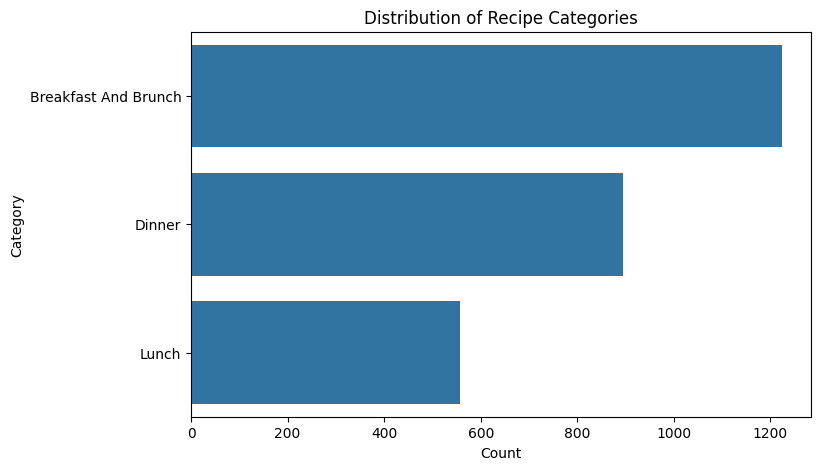

In [56]:
plt.figure(figsize=(8, 5))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Distribution of Recipe Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

Looks like we have more Breakfast recipes than the others

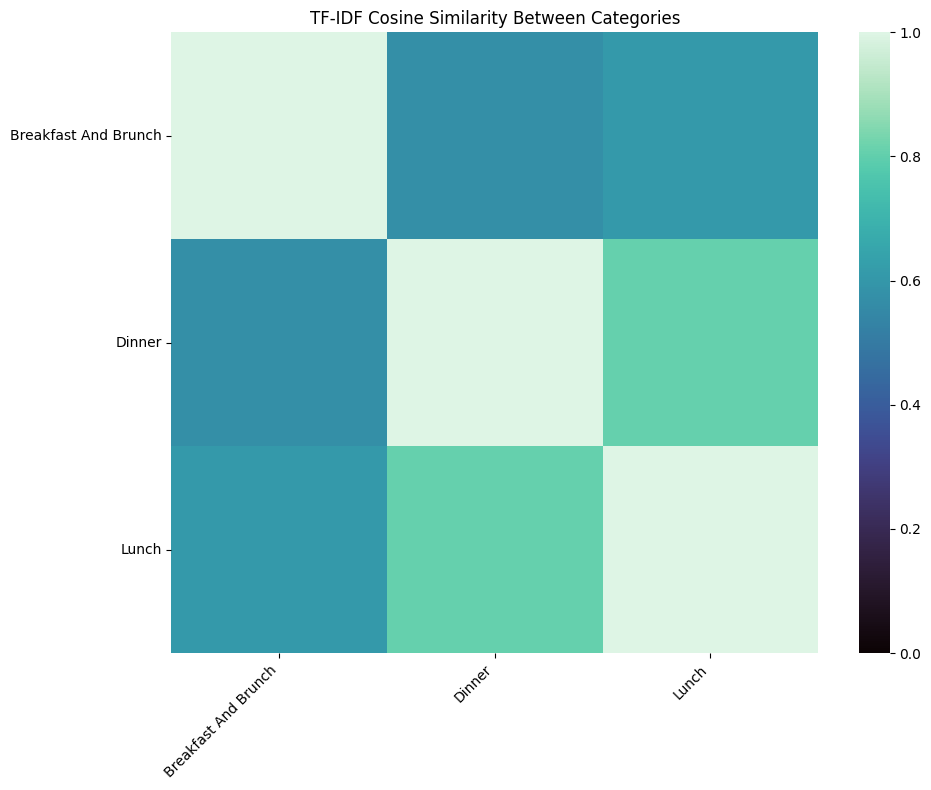

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=False, cmap="mako", vmin=0, vmax=1)
plt.title("TF-IDF Cosine Similarity Between Categories")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap shows that Lunch and Dinner recipes share similar descriptive language, while Breakfast & Brunch recipes are textually more unique — indicating that meal-type influences the vocabulary used in recipe descriptions.

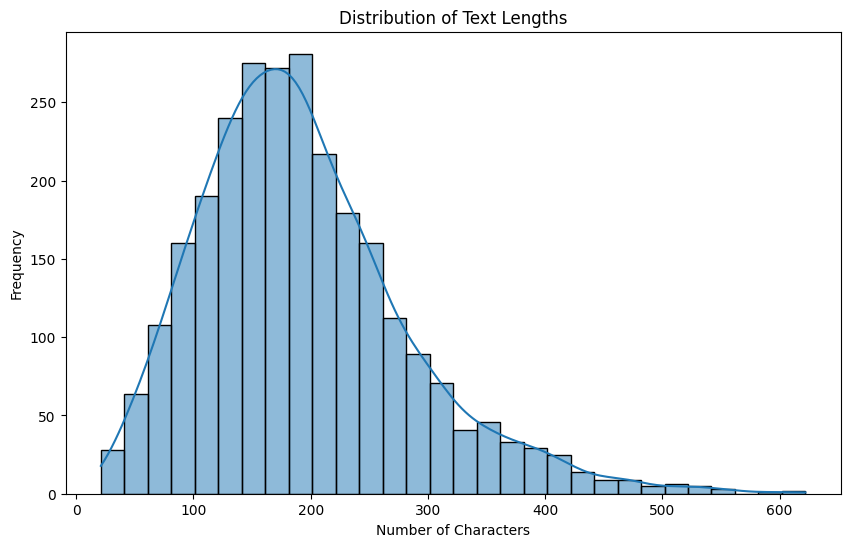

In [58]:
df['text_len'] = df['description_clean'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

Most of the recipes have their descriptions within 300characters. Lets see how the recipe description length looks like on average per category:

               category  avg_length
0  Breakfast And Brunch    194.6574
1                Dinner    193.3434
2                 Lunch    190.5386


C:\Users\GP\AppData\Local\Temp\ipykernel_23488\1990952540.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_length', y='category', data=avg_len_df, palette='viridis')


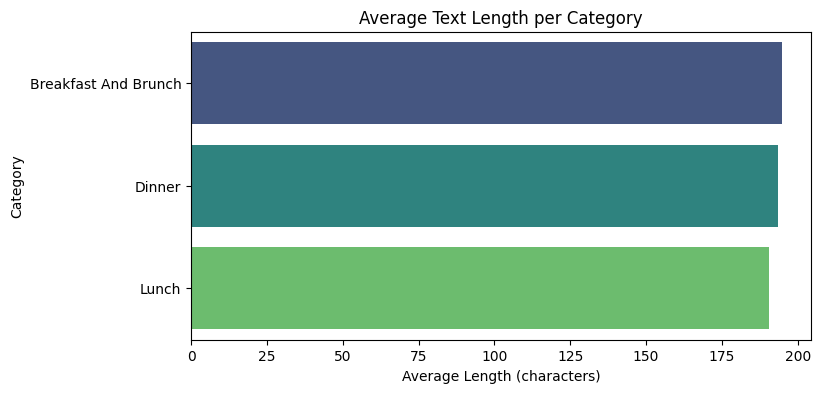

In [66]:
# Compute average length per label
avg_len = df.groupby('category')['text_len'].mean().sort_values(ascending=False)

# Display as a DataFrame
avg_len_df = avg_len.reset_index().rename(columns={'text_len': 'avg_length'})
print(avg_len_df)

# Visualize it
plt.figure(figsize=(8,4))
sns.barplot(x='avg_length', y='category', data=avg_len_df, palette='viridis')
plt.title("Average Text Length per Category")
plt.xlabel("Average Length (characters)")
plt.ylabel("Category")
plt.show()

There is no much difference in length of the descriptions by category

## 4. Pipeline 1: TF-IDF + Classical Models

This approach uses a "bag-of-words" representation. `TfidfVectorizer` converts each document into a vector where each dimension corresponds to a word, and the value is its TF-IDF score. This score is high for words that are frequent in a document but rare across all documents.

We will test two classifiers: **Logistic Regression** (a simple, fast linear model) and **Support Vector Classifier (SVC)** (a powerful model that can find complex non-linear boundaries).

In [67]:
#| label: tfidf-pipeline

# --- Pipeline with Logistic Regression ---
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('clf', LogisticRegression(random_state=42, max_iter=1000)),
])

# --- Pipeline with SVM ---
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('clf', SVC(random_state=42, kernel='linear', C=1.0)),
])

# Train models
print("Training TF-IDF + Logistic Regression...")
pipeline_lr.fit(X_train, y_train)

print("Training TF-IDF + SVM...")
pipeline_svm.fit(X_train, y_train)

# Evaluate models
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)

# Store results
results = {}
results['TF-IDF + Logistic Regression'] = accuracy_score(y_test, y_pred_lr)
results['TF-IDF + SVM'] = accuracy_score(y_test, y_pred_svm)

print("\n--- TF-IDF + Logistic Regression Results ---")
print(f"Accuracy: {results['TF-IDF + Logistic Regression']:.4f}")
print(classification_report(y_test, y_pred_lr))

print("\n--- TF-IDF + SVM Results ---")
print(f"Accuracy: {results['TF-IDF + SVM']:.4f}")
print(classification_report(y_test, y_pred_svm))

Training TF-IDF + Logistic Regression...
Training TF-IDF + SVM...

--- TF-IDF + Logistic Regression Results ---
Accuracy: 0.8445
                      precision    recall  f1-score   support

Breakfast And Brunch       0.88      0.98      0.93       306
              Dinner       0.81      0.83      0.82       224
               Lunch       0.80      0.56      0.66       139

            accuracy                           0.84       669
           macro avg       0.83      0.79      0.80       669
        weighted avg       0.84      0.84      0.84       669


--- TF-IDF + SVM Results ---
Accuracy: 0.8550
                      precision    recall  f1-score   support

Breakfast And Brunch       0.92      0.98      0.95       306
              Dinner       0.82      0.81      0.82       224
               Lunch       0.74      0.65      0.69       139

            accuracy                           0.86       669
           macro avg       0.83      0.81      0.82       669
        weigh

Both models perform quite well — roughly 85% accuracy, meaning that around 8–9 out of 10 recipes are classified into the correct category based purely on text.

**Observations**

* Breakfast & Brunch

Recall ≈ 0.98 → nearly all breakfast items are correctly caught.

Precision ≈ 0.88–0.92 → a few non-breakfast items are mistakenly labeled as breakfast.

* Lunch

Recall is lowest (0.56–0.65) → the model misses many true lunch items.

That’s expected because lunch recipes may share vocabulary with dinner.

* Dinner sits in between, balanced precision and recall (~0.82 each).

## 4. Pipeline 2: SBERT Embeddings + Classical Models

This approach uses a pre-trained Transformer model to convert text into dense, fixed-size vectors (embeddings). These embeddings capture the semantic meaning of the text, understanding context and synonyms in a way that TF-IDF cannot. We will use the `all-MiniLM-L6-v2` model, which is fast and effective.

The process is:
1.  Generate embeddings for all training and test documents.
2.  Train the same classifiers (Logistic Regression and SVM) on these embeddings.

In [68]:
#| label: sbert-pipeline

# Load a pre-trained SBERT model
print("Loading SBERT model...")
embedding_model = SentenceTransformer('intfloat/multilingual-e5-small')

# Generate embeddings (this can take a moment)
print("Generating embeddings for training data...")
X_train_embeddings = embedding_model.encode(X_train.tolist(), show_progress_bar=True)

print("Generating embeddings for test data...")
X_test_embeddings = embedding_model.encode(X_test.tolist(), show_progress_bar=True)

print(f"Shape of training embeddings: {X_train_embeddings.shape}")

# --- Train classifiers on embeddings ---
# Logistic Regression
print("\nTraining SBERT + Logistic Regression...")
clf_lr_sbert = LogisticRegression(random_state=42, max_iter=1000)
clf_lr_sbert.fit(X_train_embeddings, y_train)

# SVM
print("Training SBERT + SVM...")
clf_svm_sbert = SVC(random_state=42, kernel='linear', C=1.0)
clf_svm_sbert.fit(X_train_embeddings, y_train)

# Evaluate models
y_pred_lr_sbert = clf_lr_sbert.predict(X_test_embeddings)
y_pred_svm_sbert = clf_svm_sbert.predict(X_test_embeddings)

# Store results
results['SBERT + Logistic Regression'] = accuracy_score(y_test, y_pred_lr_sbert)
results['SBERT + SVM'] = accuracy_score(y_test, y_pred_svm_sbert)

print("\n--- SBERT + Logistic Regression Results ---")
print(f"Accuracy: {results['SBERT + Logistic Regression']:.4f}")
print(classification_report(y_test, y_pred_lr_sbert))

print("\n--- SBERT + SVM Results ---")
print(f"Accuracy: {results['SBERT + SVM']:.4f}")
print(classification_report(y_test, y_pred_svm_sbert))

Loading SBERT model...


c:\Users\GP\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GP\.cache\huggingface\hub\models--intfloat--multilingual-e5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling 

Generating embeddings for training data...


Batches: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


Generating embeddings for test data...


Batches: 100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Shape of training embeddings: (2005, 384)

Training SBERT + Logistic Regression...
Training SBERT + SVM...

--- SBERT + Logistic Regression Results ---
Accuracy: 0.8146
                      precision    recall  f1-score   support

Breakfast And Brunch       0.87      0.95      0.91       306
              Dinner       0.75      0.86      0.80       224
               Lunch       0.78      0.45      0.57       139

            accuracy                           0.81       669
           macro avg       0.80      0.75      0.76       669
        weighted avg       0.81      0.81      0.80       669


--- SBERT + SVM Results ---
Accuracy: 0.8176
                      precision    recall  f1-score   support

Breakfast And Brunch       0.88      0.94      0.91       306
              Dinner       0.76      0.83      0.80       224
               Lunch       0.74      0.52      0.61       139

            accuracy                           0.82       669
           macro avg       0.80     

Both models perform solidly, but slightly below the TF-IDF results (~84–85 %).
This shows that semantic embeddings didn’t outperform keyword-based TF-IDF for this specific dataset — likely because recipe descriptions are short and already fairly keyword-driven (“baked”, “eggs”, “grilled”, etc.).

## 5. Comparison and Conclusion

Let's summarize the accuracy scores of all four models in a single table to compare them directly.

In [69]:
results_df = pd.DataFrame(
    list(results.items()),
    columns=['Model', 'Accuracy']
).sort_values('Accuracy', ascending=False)

print(results_df.to_markdown(index=False))

| Model                        |   Accuracy |
|:-----------------------------|-----------:|
| TF-IDF + SVM                 |   0.855007 |
| TF-IDF + Logistic Regression |   0.844544 |
| SBERT + SVM                  |   0.817638 |
| SBERT + Logistic Regression  |   0.814649 |


Among all models tested, TF-IDF-based approaches outperformed SBERT embeddings for recipe category classification.
The TF-IDF + SVM model achieved the highest accuracy (≈ 85.5 %), followed closely by TF-IDF + Logistic Regression (≈ 84.4 %).
Semantic models using SBERT delivered slightly lower accuracies (≈ 81–82 %), indicating that in this dataset, keyword-level features captured category distinctions more effectively than sentence-level semantic embeddings